# Sharpen with bilinear

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/M_DV_V2022

Mounted at /content/gdrive
/content/gdrive/MyDrive/M_DV_V2022


In [2]:
from tensorflow.keras.layers import Input, Dense, ReLU, Add, Conv1D, BatchNormalization, LayerNormalization, Layer, Flatten, MaxPooling1D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras import losses
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
import numpy as np
import h5py
import pandas as pd
import tensorflow as tf
from tensorflow.image import resize


### Set up for up and down scaling

In [3]:
def rationalConv(x, filters=16, kernel_size=(3,3), padding="same", start=7, end=3):
    """
    Where ordinary convolutions down-scale by an integer stride, 
    the rational version up-samples and down-scales an integer stride to 
    reach a desired rational upscaling.

    Example: 7 -> 3 => 7 * bilinear(9/7) = 9, 9 / conv(3) = 3
    """
    size = x.shape
    stride = np.ceil(start/end).astype(int)
    scaling = (end*stride)/start
    
    x = resize(x, tf.constant(np.round([size[1]*scaling, size[2]*scaling]), dtype="int32"))
    if stride > 1:
        x = Conv2D(filters=filters, kernel_size=kernel_size, strides = (stride,stride), padding=padding)(x)
    return x

def rationalConvTransposed(x, filters=16, kernel_size=(3,3), padding="same", start=3, end=7):
    """
    Where ordinary transposed convolutions up-scale by an integer stride, 
    the rational version up-scales an integer stride and down-samples to 
    reach a desired rational upscaling.
    
    Example: 3 -> 7 => 3 * convTr(3) = 9, 9 * bilinear(7/9) = 7
    """
    size = x.shape
    stride = np.ceil(end/start).astype(int)
    scaling = end/start
    
    if stride > 1:
        x = Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides = (stride,stride), padding=padding)(x)
    x = resize(x, tf.constant(np.round([size[1]*scaling, size[2]*scaling]), dtype="int32"))
    return x

"""
Version of U-Net with dropout and size preservation (padding= 'same')
""" 
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x


def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True, n_classes = 2):
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    #outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
    return c9
    #model = Model(inputs=[input_img], outputs=[outputs])
    #return 



In [11]:

input_img = Input(shape=(55,55,3))

x = rationalConvTransposed(input_img, filters=32,end=7, start=3)
x = Conv2D(3, kernel_size=3, padding="same", activation='linear')(x)
x = get_unet(input_img=x, n_classes=1)


x = Conv2D(3, kernel_size=1, padding="same", activation='linear')(x)

model = Model(inputs = [input_img], outputs = [x])
model.compile(optimizer='adam',
              loss='mse')
#model.summary()

## Load data - show data

In [6]:
X = np.load("sharpen/X_data.npy")
y = np.load("sharpen/y_data.npy")

X = X[:,:,:,:]
y = y[:,:,:,:]

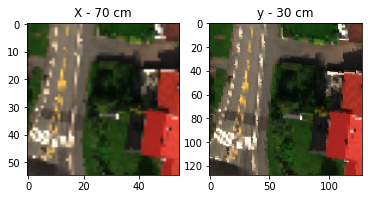

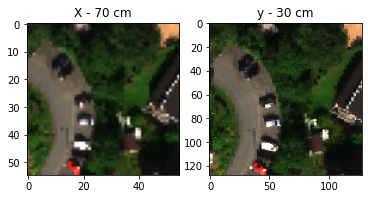

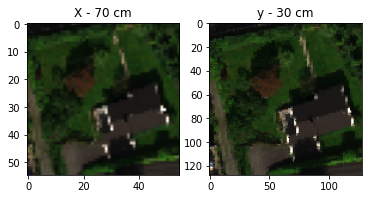

In [ ]:
indx = np.random.randint(0,high=X.shape[0],size=3)
for i in range(3):
  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
  ax1.imshow(X[indx[i]]); ax1.set_title("X - 70 cm")
  ax2.imshow(y[indx[i]]); ax2.set_title("y - 30 cm")
  plt.show()

In [ ]:
y.shape

(50, 128, 128, 3)

In [12]:
h = model.fit(X,y,
              batch_size=10,
              epochs=550)

Epoch 1/550
5/5 [==============================] - 3s 31ms/step - loss: 0.7713
Epoch 2/550
5/5 [==============================] - 0s 32ms/step - loss: 0.3615
Epoch 3/550
5/5 [==============================] - 0s 31ms/step - loss: 0.1946
Epoch 4/550
5/5 [==============================] - 0s 31ms/step - loss: 0.1124
Epoch 5/550
5/5 [==============================] - 0s 30ms/step - loss: 0.0708
Epoch 6/550
5/5 [==============================] - 0s 30ms/step - loss: 0.0485
Epoch 7/550
5/5 [==============================] - 0s 31ms/step - loss: 0.0363
Epoch 8/550
5/5 [==============================] - 0s 30ms/step - loss: 0.0295
Epoch 9/550
5/5 [==============================] - 0s 30ms/step - loss: 0.0251
Epoch 10/550
5/5 [==============================] - 0s 31ms/step - loss: 0.0230
Epoch 11/550
5/5 [==============================] - 0s 30ms/step - loss: 0.0207
Epoch 12/550
5/5 [==============================] - 0s 31ms/step - loss: 0.0196
Epoch 13/550
5/5 [==============================]

Text(0, 0.5, 'mse loss')

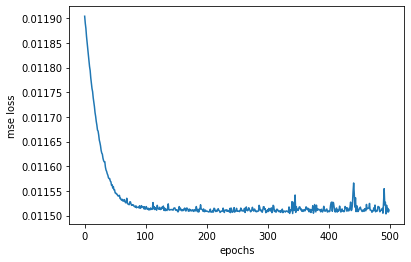

In [8]:
plt.plot(h.history['loss'][50:])
plt.xlabel("epochs"); plt.ylabel("mse loss")

[20 45 17]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


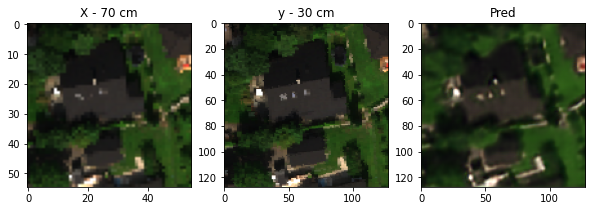

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


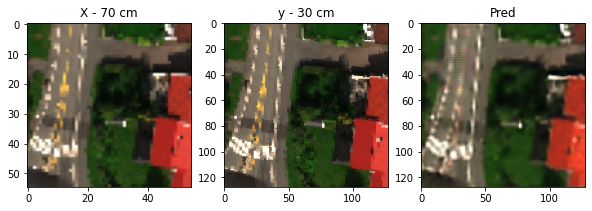

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


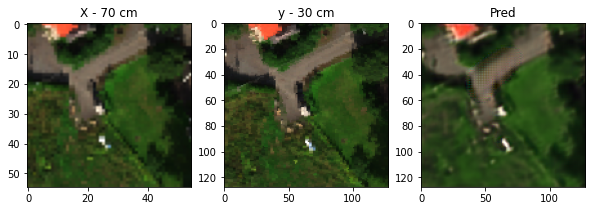

In [13]:
indx = np.random.randint(0,high=X.shape[0],size=3)
print(indx)
for i in range(3):
  fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(10,10))
  pred = model.predict(X[indx[i]:indx[i]+1])[0]
  ax1.imshow(X[indx[i]]); ax1.set_title("X - 70 cm")
  ax2.imshow(y[indx[i]]); ax2.set_title("y - 30 cm")
  ax3.imshow(pred[:,:,:]); ax3.set_title("Pred")
  plt.show()


In [14]:
sample_model = Model(inputs=model.input, outputs=[model.layers[-38].output])

In [15]:
sample_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 55, 55, 3)]       0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 165, 165, 32)     896       
 ranspose)                                                       
                                                                 
 tf.image.resize_2 (TFOpLamb  (None, 128, 128, 32)     0         
 da)                                                             
                                                                 
 conv2d_21 (Conv2D)          (None, 128, 128, 3)       867       
                                                                 
 conv2d_22 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 batch_normalization_18 (Bat  (None, 128, 128, 16)     64  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


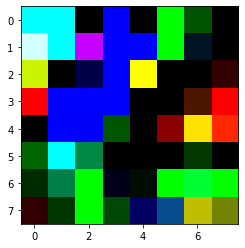

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


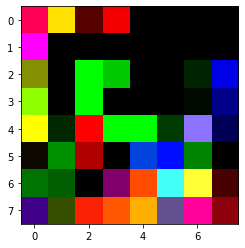

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


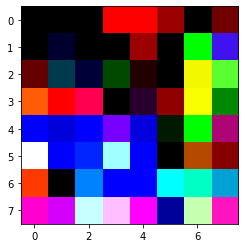

In [19]:
pred = sample_model.predict(X[31:32])[0]
plt.imshow(pred[:,:,0:3]); plt.show()
plt.imshow(pred[:,:,3:6]); plt.show()
plt.imshow(pred[:,:,6:9]); plt.show()


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pred = sample_model.predict(X[31:32])[0]

pred.shape

(8, 8, 256)

In [ ]:
a = pca.fit_transform(pred.reshape(8*8, 256))
a = a.reshape(8,8,3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


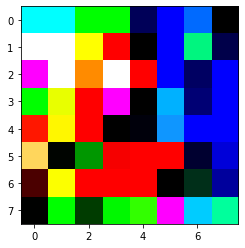

In [ ]:
plt.imshow(a)